In [78]:
# Assignment 1
# Relationship between solar radio flux F10.7 and sunspot number
# Team 2:
#     Ekaterina Karmanova
#     Timur Chikichev
#     Iaroslav Okunevich
#     Nikita Mikhailovskiy
#
# Skoltech, 01.10.2019

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#Data parsing from file
filename = './data/txt/data_group2.txt'
data = np.loadtxt(filename,dtype={'names': ('year', 'month', 'flux', 'sunspots'),
                     'formats': ('i4', 'i4', 'f4','f4')})
years = np.array(data['year'])
monthes = np.array(data['month'])
flux = data['flux']
spots = data['sunspots']

In [80]:
#Parsing years and monthes to get proper timestamp
from datetime import date

dates = [date(years[i], monthes[i],int(1)) for i in range (0,years.size)]

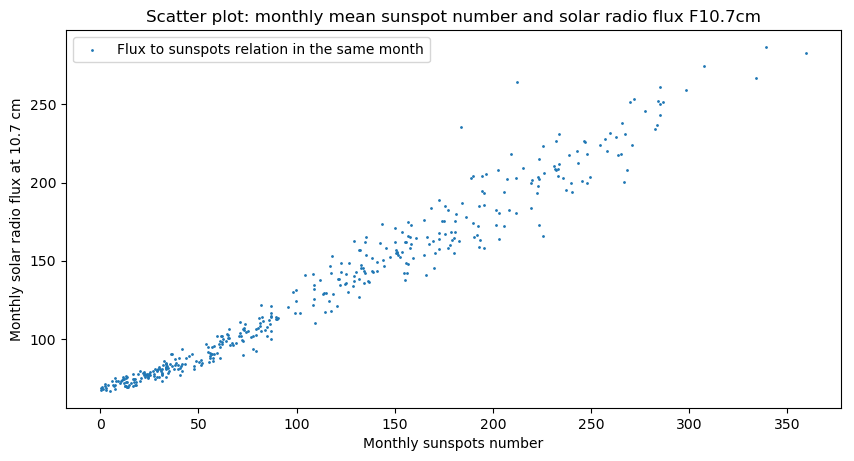

In [81]:
#Scatter plot creation - Flux = f(Sunspots)
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(spots, flux, 1, label = 'Flux to sunspots relation in the same month')
plt.title('Scatter plot: monthly mean sunspot number and solar radio flux F10.7cm')
plt.ylabel('Monthly solar radio flux at 10.7 cm')
plt.xlabel('Monthly sunspots number')
plt.legend()
plt.show()

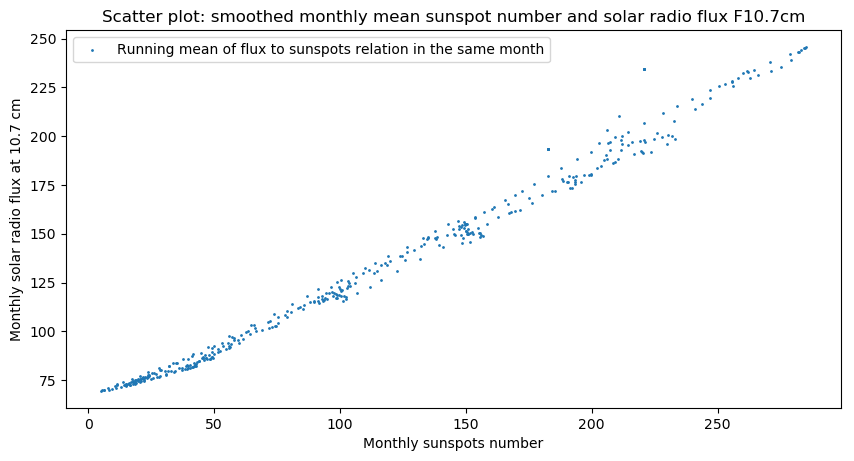

In [82]:
def smooth_13(array):
    '''running mean smoothing function with frame width = 13'''
    length = array.size    
    wide = 6
    
    #Pre-calculation: mean of the first and last six entries in dataset
    sum_first = 0
    sum_last = 0
    for i in range (wide):
        sum_first += array[i]
        sum_last += array[length - i - 1]
    
    def smooth(i, wide = 6):
        #last values (less weighted)
        res = (array[i - wide] + array[i + wide]) / wide / 4.
        #middle values sum2         
        s2 = 0
        for it in range (i - wide + 1, i + wide):
            s2 += array[it]
        res += s2 / wide / 2.
        return res
    
    smooth_arr = [sum_first / wide] * wide
    smooth_arr += [smooth(i) for i in range(wide, length - wide)]
    smooth_arr += [sum_last / wide] * wide
    return np.array(smooth_arr)

#Calculation to subtract noise for flux and sunspots dataset
s_flux = smooth_13(flux)
s_spots = smooth_13(spots)

#Scatter plot - Flux = f(Sunspots) without noise
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(s_spots, s_flux, 1, label='Running mean of flux to sunspots relation in the same month')
plt.title('Scatter plot: smoothed monthly mean sunspot number and solar radio flux F10.7cm')
plt.ylabel('Monthly solar radio flux at 10.7 cm')
plt.xlabel('Monthly sunspots number')
plt.legend()
plt.show()      

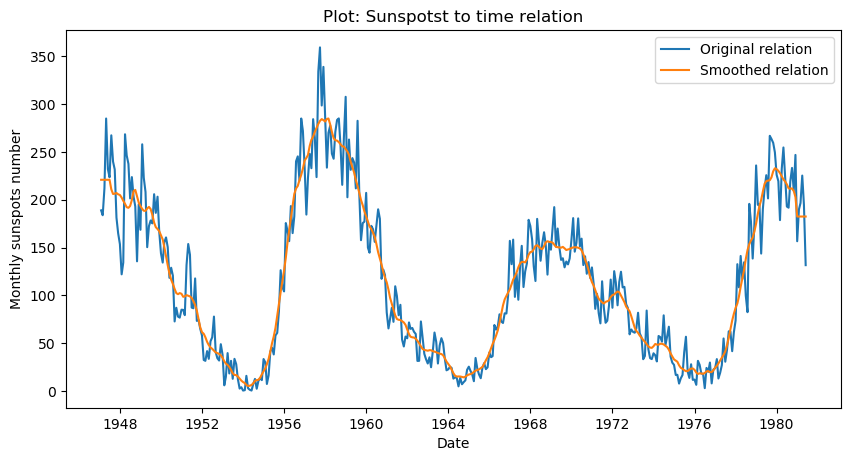

In [83]:
#Plot - Sunspots = f(Time), original and smoothed
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot: Sunspotst to time relation')

plt.plot(dates, spots, label='Original relation')
plt.plot(dates,  smooth_13(spots), label='Smoothed relation')
plt.xlabel('Date')
plt.ylabel('Monthly sunspots number')
plt.legend()
plt.show()

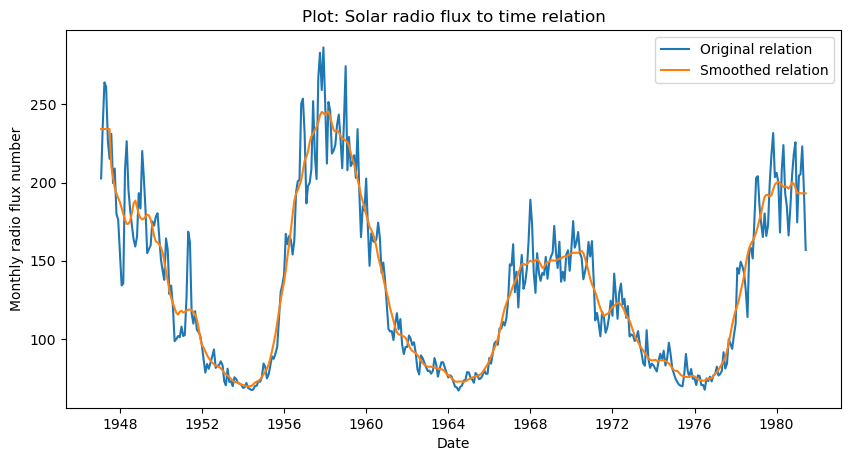

In [84]:
#Plot - Flux = f(Time), original and smoothed
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot: Solar radio flux to time relation')

plt.plot(dates, flux, label='Original relation')
plt.plot(dates,  smooth_13(flux), label='Smoothed relation')
plt.xlabel('Date')
plt.ylabel('Monthly radio flux number')
plt.legend()
plt.show()

In [85]:
#Defining – Vector of dependent variables, regressand
F = flux.reshape(len(s_flux),1)

#Defining – Matrix of independent variables, regressors 
R = np.zeros((len(s_spots),4)).reshape(len(s_spots),4)
for i in range (0,len(s_spots)):
    R[i][0] = 1;
    R[i][1] = s_spots[i];
    R[i][2] = s_spots[i]**2;
    R[i][3] = s_spots[i]**3;

#Calculating the vector of coefficients by LSM
#Find transpose of regressors matrix
tr = R.transpose()
#Multiplicating of transposed regressors with original one
first = np.dot(tr,R)
#Inverse the result of multiplicating
inv = np.linalg.inv(first)
#Multiplicating of inversed result with transposed regressor
second = np.dot(inv,tr)
#Calculating vector of coefficients by multiplying previous result with regressand 
betta = np.dot(second, F)

print(betta)


[[ 6.36819324e+01]
 [ 4.69802294e-01]
 [ 1.19386419e-03]
 [-2.03526594e-06]]


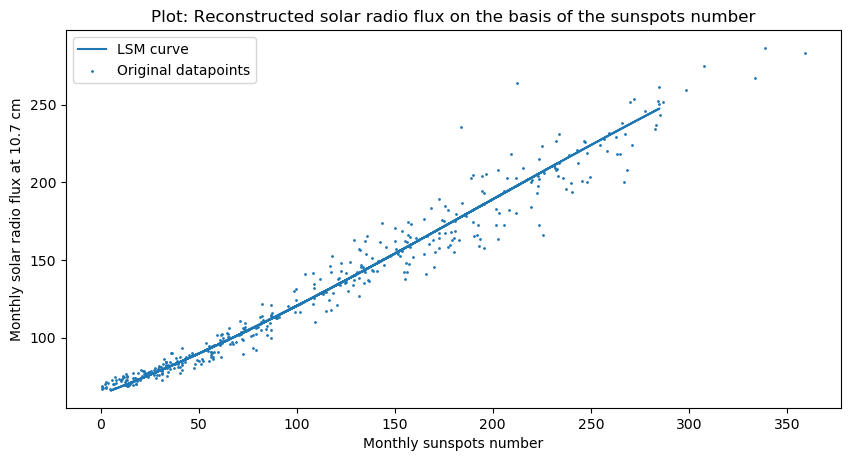

In [86]:
#Reconstruction of flux by using LSM calculated coefficients
def flux_recon():
    flux_recon_  = [np.sum([betta[k] * s_spots[i]**k for k in range(4)]) for i in range (0,len(s_spots))]
    return np.array(flux_recon_)

flux_reconstructed = flux_recon()

#Plot - Reconstructed Flux = f(Sunspots)
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot: Reconstructed solar radio flux on the basis of the sunspots number')

plt.plot(s_spots, flux_reconstructed, label='LSM curve')
plt.scatter(spots, flux, 1, label='Original datapoints')
plt.ylabel('Monthly solar radio flux at 10.7 cm')
plt.xlabel('Monthly sunspots number')
plt.legend()
plt.show()  

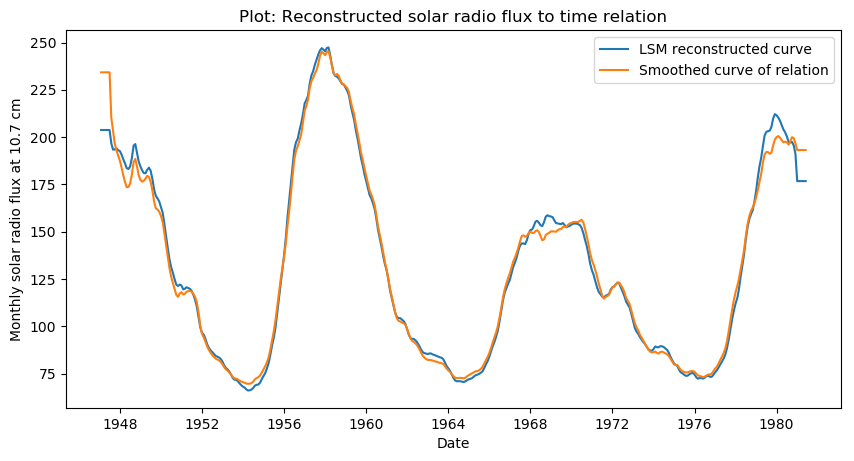

In [87]:
#Plot - Reconstructed Flux = f(Time)
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.plot(dates, flux_reconstructed, label='LSM reconstructed curve')
plt.plot(dates, s_flux, label='Smoothed curve of relation')
plt.title('Plot: Reconstructed solar radio flux to time relation')
plt.ylabel('Monthly solar radio flux at 10.7 cm')
plt.xlabel('Date')
plt.legend()
plt.show()  

In [88]:
#Variance of estimation error of solar radio flux at 10.7
s2 = 0
for i in range (0,len(s_flux)):
    s2 += (s_flux[i] - flux_reconstructed[i])**2
delta2 = 1. * s2/(len(s_flux)-1)
print(delta2)

33.09042823837176
